In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import sentencepiece as spm
import json

In [10]:
vocab_file = "./web-crawler/kowiki/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [11]:
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
print(inputs.size())
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3189, 3552,  198, 3904, 3708, 3538,    0,    0],
        [ 201, 3554,   53, 3780, 3544, 3631, 3708, 3538]])


In [12]:
n_vocab = len(vocab)
d_hidn = 128
nn_emb = nn.Embedding(n_vocab, d_hidn)

input_embs = nn_emb(inputs)
input_embs.size()

torch.Size([2, 8, 128])

In [14]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


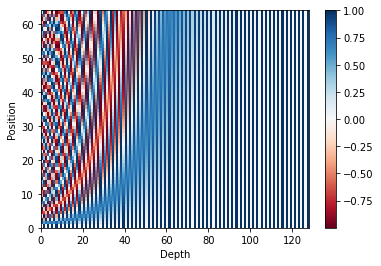

In [17]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print(pos_encoding.shape)
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [19]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions)

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3189, 3552,  198, 3904, 3708, 3538,    0,    0],
        [ 201, 3554,   53, 3780, 3544, 3631, 3708, 3538]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


In [21]:
input_sums = input_embs + pos_embs

In [22]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


In [33]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[158.8233,  54.8743,  66.4653,  39.7264,  36.7451,  31.3480,  62.7215,
          62.7215],
        [ 54.8743, 161.7897,  56.1892,  37.0268,  50.9747,  22.3163,  51.4187,
          51.4187],
        [ 66.4653,  56.1892, 227.2513,  53.3758,  35.5987,  55.0619,  56.3467,
          56.3467],
        [ 39.7264,  37.0268,  53.3758, 187.8401,  53.8145,  57.6701,  80.9126,
          80.9126],
        [ 36.7451,  50.9747,  35.5987,  53.8145, 174.1450,  47.3574,  45.9128,
          45.9128],
        [ 31.3480,  22.3163,  55.0619,  57.6701,  47.3574, 174.2686,  51.9389,
          51.9389],
        [ 62.7215,  51.4187,  56.3467,  80.9126,  45.9128,  51.9389, 229.3652,
         229.3652],
        [ 62.7215,  51.4187,  56.3467,  80.9126,  45.9128,  51.9389, 229.3652,
         229.3652]], grad_fn=<SelectBackward>)


In [34]:
d_head = 64
scores = scores.mul_(1 / d_head ** 0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[19.8529,  6.8593,  8.3082,  4.9658,  4.5931,  3.9185,  7.8402,  7.8402],
        [ 6.8593, 20.2237,  7.0237,  4.6283,  6.3718,  2.7895,  6.4273,  6.4273],
        [ 8.3082,  7.0237, 28.4064,  6.6720,  4.4498,  6.8827,  7.0433,  7.0433],
        [ 4.9658,  4.6283,  6.6720, 23.4800,  6.7268,  7.2088, 10.1141, 10.1141],
        [ 4.5931,  6.3718,  4.4498,  6.7268, 21.7681,  5.9197,  5.7391,  5.7391],
        [ 3.9185,  2.7895,  6.8827,  7.2088,  5.9197, 21.7836,  6.4924,  6.4924],
        [ 7.8402,  6.4273,  7.0433, 10.1141,  5.7391,  6.4924, 28.6707, 28.6707],
        [ 7.8402,  6.4273,  7.0433, 10.1141,  5.7391,  6.4924, 28.6707, 28.6707]],
       grad_fn=<SelectBackward>)


In [35]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 1.9853e+01,  6.8593e+00,  8.3082e+00,  4.9658e+00,  4.5931e+00,
          3.9185e+00, -1.0000e+09, -1.0000e+09],
        [ 6.8593e+00,  2.0224e+01,  7.0237e+00,  4.6283e+00,  6.3718e+00,
          2.7895e+00, -1.0000e+09, -1.0000e+09],
        [ 8.3082e+00,  7.0237e+00,  2.8406e+01,  6.6720e+00,  4.4498e+00,
          6.8827e+00, -1.0000e+09, -1.0000e+09],
        [ 4.9658e+00,  4.6283e+00,  6.6720e+00,  2.3480e+01,  6.7268e+00,
          7.2088e+00, -1.0000e+09, -1.0000e+09],
        [ 4.5931e+00,  6.3718e+00,  4.4498e+00,  6.7268e+00,  2.1768e+01,
          5.9197e+00, -1.0000e+09, -1.0000e+09],
        [ 3.9185e+00,  2.7895e+00,  6.8827e+00,  7.2088e+00,  5.9197e+00,
          2.1784e+01, -1.0000e+09, -1.0000e+09],
        [ 7.8402e+00,  6.4273e+00,  7.0433e+00,  1.0114e+01,  5.7391e+00,
          6.4924e+00, -1.0000e+09, -1.0000e+09],
        [ 7.8402e+00,  6.4273e+00,  7.0433e+00,  1.0114e+01,  5.7391e+00,
          6.4924e+00, -1.0000e+09, -1.0000e

In [36]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[9.9999e-01, 2.2747e-06, 9.6865e-06, 3.4245e-07, 2.3591e-07, 1.2016e-07,
         0.0000e+00, 0.0000e+00],
        [1.5700e-06, 1.0000e+00, 1.8505e-06, 1.6866e-07, 9.6428e-07, 2.6818e-08,
         0.0000e+00, 0.0000e+00],
        [1.8683e-09, 5.1711e-10, 1.0000e+00, 3.6379e-10, 3.9427e-11, 4.4915e-10,
         0.0000e+00, 0.0000e+00],
        [9.1071e-09, 6.4987e-09, 5.0161e-08, 1.0000e+00, 5.2989e-08, 8.5800e-08,
         0.0000e+00, 0.0000e+00],
        [3.4753e-08, 2.0582e-07, 3.0114e-08, 2.9352e-07, 1.0000e+00, 1.3095e-07,
         0.0000e+00, 0.0000e+00],
        [1.7430e-08, 5.6364e-09, 3.3779e-07, 4.6800e-07, 1.2894e-07, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.4793e-02, 2.0643e-02, 3.8220e-02, 8.2394e-01, 1.0372e-02, 2.2030e-02,
         0.0000e+00, 0.0000e+00],
        [8.4793e-02, 2.0643e-02, 3.8220e-02, 8.2394e-01, 1.0372e-02, 2.2030e-02,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>)


In [37]:
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


In [50]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)

    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        
        attn_prob = nn.Softmax(dim=-1)(scores)

        context = torch.matmul(attn_prob, V)

        return context, attn_prob

In [51]:
Q = K = V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

In [52]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

q_s = W_Q(Q)
print(q_s.size())

q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())

q_s = q_s.transpose(1, 2)
print(q_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [53]:
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1, 2)

k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1, 2)

v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1, 2)

q_s.size(), k_s.size(), v_s.size()

(torch.Size([2, 2, 8, 64]),
 torch.Size([2, 2, 8, 64]),
 torch.Size([2, 2, 8, 64]))

In [54]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


In [55]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


In [56]:
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


In [57]:
linear = nn.Linear(n_head * d_head, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


In [58]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)

        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        output = self.linear(context)

        return output, attn_prob

In [59]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


In [60]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


In [61]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 8])


In [63]:
active = F.gelu
ff_2 = active(ff_1)

In [64]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


In [65]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn*4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn*4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return output

In [67]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, "r") as f:
            config = json.loads(f.read())
            return Config(config)

In [68]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}
